In [1]:
def modificar_geo(archivo_entrada, archivo_salida, nuevo_n, nuevo_r):
    with open(archivo_entrada, "r") as f:
        lineas = f.readlines()

    nuevas_lineas = []
    for linea in lineas:
        if linea.strip().startswith("n ="):
            nuevas_lineas.append(f"n = {nuevo_n};\n")
        elif linea.strip().startswith("r ="):
            nuevas_lineas.append(f"r = {nuevo_r};\n")
        elif "Transfinite Curve{1, 2}" in linea:
            nuevas_lineas.append(f"Transfinite Curve{{1, 2}} = {nuevo_n} Using Progression {nuevo_r};\n")
        elif "Transfinite Curve{4, 3}" in linea:
            nuevas_lineas.append(f"Transfinite Curve{{4, 3}} = {nuevo_n} Using Progression 1/{nuevo_r};\n")
        else:
            nuevas_lineas.append(linea)

    with open(archivo_salida, "w") as f:
        f.writelines(nuevas_lineas)

    print(f"Archivo guardado como '{archivo_salida}' con n = {nuevo_n} y r = {nuevo_r}")


In [2]:
modificar_geo("geo.geo", "geo.geo", nuevo_n=20, nuevo_r=1.3)

Archivo guardado como 'geo.geo' con n = 20 y r = 1.3


In [3]:
import gmsh
import meshio
from nodes import Node
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import gmsh
import meshio
from nodes import Node
from elements import LST

import gmsh
import meshio

import gmsh
import meshio
import numpy as np

def fixed_load_mesh_objects(geo_file="geo.geo", msh_file="mesh.msh"):
    gmsh.initialize()
    gmsh.open(geo_file)
    gmsh.option.setNumber("Mesh.ElementOrder", 2)
    gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
    gmsh.model.mesh.generate(2)

    # Obtener todos los nodos y sus coordenadas
    all_tags, all_coords, _ = gmsh.model.mesh.getNodes()
    all_coords = all_coords.reshape(-1, 3)
    tag_to_xy = {tag: (round(x, 8), round(y, 8)) for tag, (x, y, _) in zip(all_tags, all_coords)}

    # Leer archivo de malla en paralelo
    mesh = meshio.read(msh_file)

    # Crear nodos con índices base 1
    nodes = [Node(i + 1, x, y) for i, (x, y, _) in enumerate(mesh.points)]

    # Mapear coordenadas → índice base 1
    coord_to_index = {(round(x, 8), round(y, 8)): i + 1 for i, (x, y, _) in enumerate(mesh.points)}

    # Buscar nodos de borde
    boundary_nodes = {}
    for dim in [1]:
        phys_groups = gmsh.model.getPhysicalGroups(dim)
        for _, tag in phys_groups:
            node_indices = set()
            entities = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
            for entity in entities:
                element_type, element_tags, node_tags = gmsh.model.mesh.getElements(dim, entity)
                for nlist in node_tags:
                    for node_id in nlist:
                        node_indices.add(node_id)  # usamos el ID original, no mapeo por coordenadas
            boundary_nodes[tag] = node_indices

    gmsh.write(msh_file)
    gmsh.finalize()

    # Crear elementos LST
    lst_elements = []
    for cell_block in mesh.cells:
        if cell_block.type in ["triangle6", "triangle"]:
            for i, node_ids in enumerate(cell_block.data):
                if len(node_ids) == 6:
                    node_ids = [int(id) + 1 for id in node_ids]
                    lst_elements.append(LST(i + 1, node_ids))

    # Asignar etiquetas
    for node in nodes:
        node.boundary_label = []
        for tag, ids in boundary_nodes.items():
            if node.id in ids:
                print(f"Node {node.id} is on boundary with tag {tag}")
                node.boundary_label.append(f"Dirichlet")

    print(f"{boundary_nodes=}")
    for node in nodes:
        if node.boundary_label:
            print(f"Node {node.id} has boundary label: {node.boundary_label}")
    print(f"{boundary_nodes=}")
    return nodes, lst_elements

import numpy as np
import matplotlib.pyplot as plt

def plot_mesh(nodes, elements, show_node_ids=False, show_elem_ids=False):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    for elem in elements:
        # Coordenadas de los 6 nodos del elemento (en orden)
        coords = np.array([[nodes[nid - 1].x, nodes[nid - 1].y] for nid in elem.node_ids])

        # Lado 1-2 con nodo medio 4
        ax.plot(
            [coords[0][0], coords[3][0], coords[1][0]],
            [coords[0][1], coords[3][1], coords[1][1]],
            color='gray', linewidth=1
        )

        # Lado 2-3 con nodo medio 5
        ax.plot(
            [coords[1][0], coords[4][0], coords[2][0]],
            [coords[1][1], coords[4][1], coords[2][1]],
            color='gray', linewidth=1
        )

        # Lado 3-1 con nodo medio 6
        ax.plot(
            [coords[2][0], coords[5][0], coords[0][0]],
            [coords[2][1], coords[5][1], coords[0][1]],
            color='gray', linewidth=1
        )

    # Mostrar nodos
    if show_node_ids:
        for node in nodes:
            ax.text(node.x, node.y, str(node.id), color='blue', fontsize=7, ha='center', va='center')

    # Mostrar ID de elementos
    if show_elem_ids:
        for elem in elements:
            coords = np.array([[nodes[j - 1].x, nodes[j - 1].y] for j in elem.node_ids[:3]])
            centroid = coords.mean(axis=0)
            ax.text(*centroid, str(elem.id), color='red', fontsize=8, ha='center')

    ax.set_title("Malla de elementos triangulares (LST)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.tight_layout()
    plt.show()



Info    : Reading 'geo.geo'...
Info    : Done reading 'geo.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000671916s, CPU 0.000695s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.000174459s, CPU 0.000169s)
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 30%] Meshing curve 2 order 2
Info    : [ 50%] Meshing curve 3 order 2
Info    : [ 70%] Meshing curve 4 order 2
Info    : [ 90%] Meshing surface 1 order 2
Info    : Surface mesh: worst distortion = 1 (0 elements in ]0, 0.2]); worst gamma = 0.0177051
Info    : Done meshing order 2 (Wall 0.00148696s, CPU 0.001412s)
Info    : 1521 nodes 802 elements

Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'
Node 1 is on boundary with tag 2
Node 1 is on boun

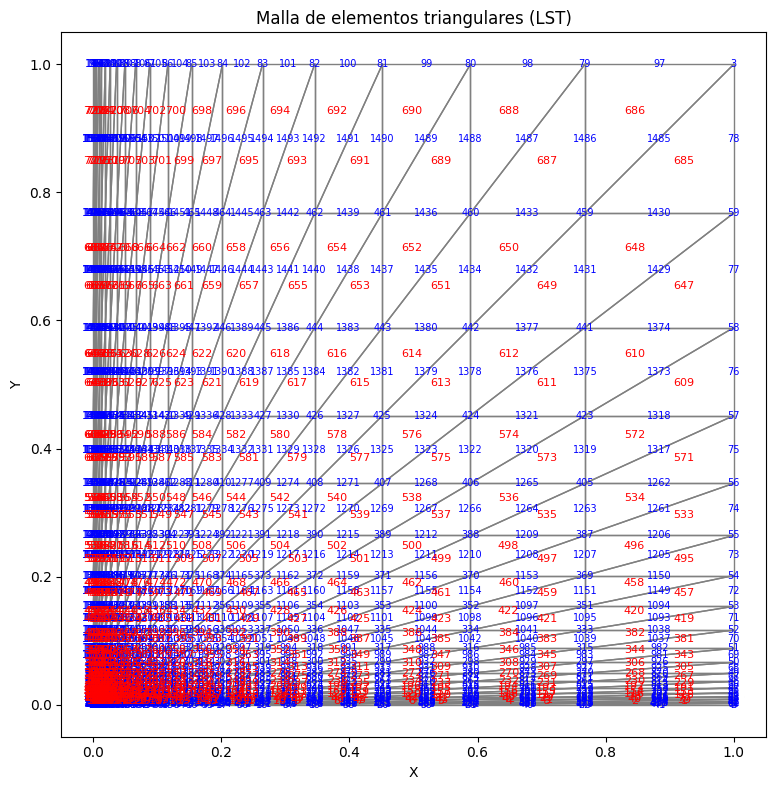

In [4]:
nodes, elements = fixed_load_mesh_objects("geo.geo", "mesh.msh")
plot_mesh(nodes, elements, show_node_ids=True, show_elem_ids=True)


In [5]:
#Ahora debo calcular la solucion u
alpha = 3

for node in nodes:
    node.solve_u(alpha)

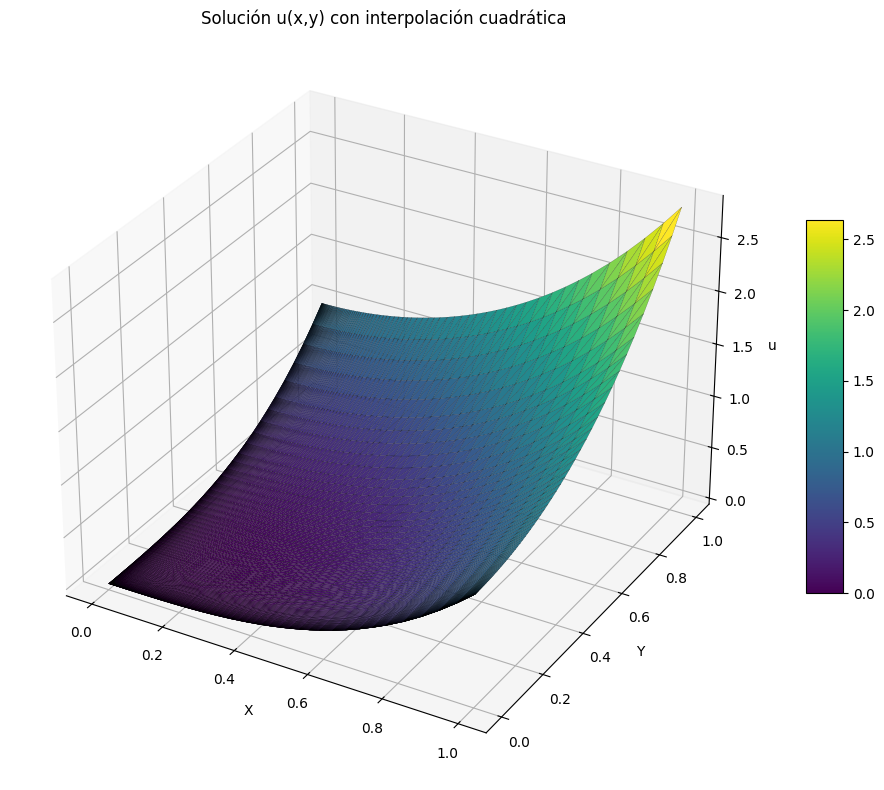

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation

def plot_u_surface_quadratic_elements(nodes, elements, use_attr="u_fem", n_sub=5):
    """
    Grafica u(x,y) como superficie suave evaluando por elemento LST con funciones cuadráticas.
    Cada triángulo se subdivide en sub-triángulos interpolados con 6 nodos.
    """
    def shape_functions_LST(xi, eta):
        """Funciones de forma cuadráticas en coordenadas de área (LST)"""
        L1 = 1 - xi - eta
        L2 = xi
        L3 = eta
        return np.array([
            L1 * (2 * L1 - 1),
            L2 * (2 * L2 - 1),
            L3 * (2 * L3 - 1),
            4 * L1 * L2,
            4 * L2 * L3,
            4 * L3 * L1
        ])

    # Subdivisión uniforme del triángulo de referencia
    xi_vals = []
    eta_vals = []
    for i in range(n_sub + 1):
        for j in range(n_sub + 1 - i):
            xi_vals.append(i / n_sub)
            eta_vals.append(j / n_sub)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    X_all, Y_all, Z_all, tri_all = [], [], [], []
    base_idx = 0

    for elem in elements:
        if len(elem.node_ids) != 6:
            continue

        coords = np.array([[nodes[i - 1].x, nodes[i - 1].y] for i in elem.node_ids])
        u_vals = np.array([getattr(nodes[i - 1], use_attr) for i in elem.node_ids])

        local_X, local_Y, local_Z = [], [], []

        for xi, eta in zip(xi_vals, eta_vals):
            N = shape_functions_LST(xi, eta)
            xy = N @ coords
            u = N @ u_vals

            local_X.append(xy[0])
            local_Y.append(xy[1])
            local_Z.append(u)

        # Crear triangulación local
        pts = []
        for i in range(n_sub + 1):
            for j in range(n_sub + 1 - i):
                pts.append((i, j))

        tri = []
        for i in range(n_sub):
            for j in range(n_sub - i):
                a = i * (n_sub + 1) - (i * (i - 1)) // 2 + j
                b = a + 1
                c = a + (n_sub + 1 - i)
                tri.append([base_idx + a, base_idx + b, base_idx + c])
                if j < n_sub - i - 1:
                    d = c + 1
                    tri.append([base_idx + b, base_idx + d, base_idx + c])

        X_all.extend(local_X)
        Y_all.extend(local_Y)
        Z_all.extend(local_Z)
        tri_all.extend(tri)
        base_idx += len(local_X)

    triang = Triangulation(X_all, Y_all, tri_all)
    surf = ax.plot_trisurf(triang, Z_all, cmap='viridis', edgecolor='k', linewidth=0.1)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel(use_attr)
    ax.set_title(f"Solución {use_attr}(x,y) con interpolación cuadrática")

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

plot_u_surface_quadratic_elements(nodes, elements, use_attr="u")   


In [7]:
#Bien, ahora es nesesario ensamblar la stifnes matrix de cada elemento CST
from solve import Solve

Estructure = Solve(nodes, elements, alpha)



✅ Norm(K_global) = 2.354e+03


🔒 Nodos con Dirichlet: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151]
🔧 Tamaño de K_global: (1521, 1521)
🔧 Tamaño de f: (1521,)
[0. 0. 0. ... 0. 0. 0.]
🟩 Nodos marcados como Dirichlet: 152
📦 Norm(f) = 0.000e+00
🔒 Nodos con Dirichlet = 152
[-1.50033152e+01 -5.20958926e+00 -1.80488994e+00 ...  1.54137806e-02
  1.36351193e-02  1.03528798e+02]


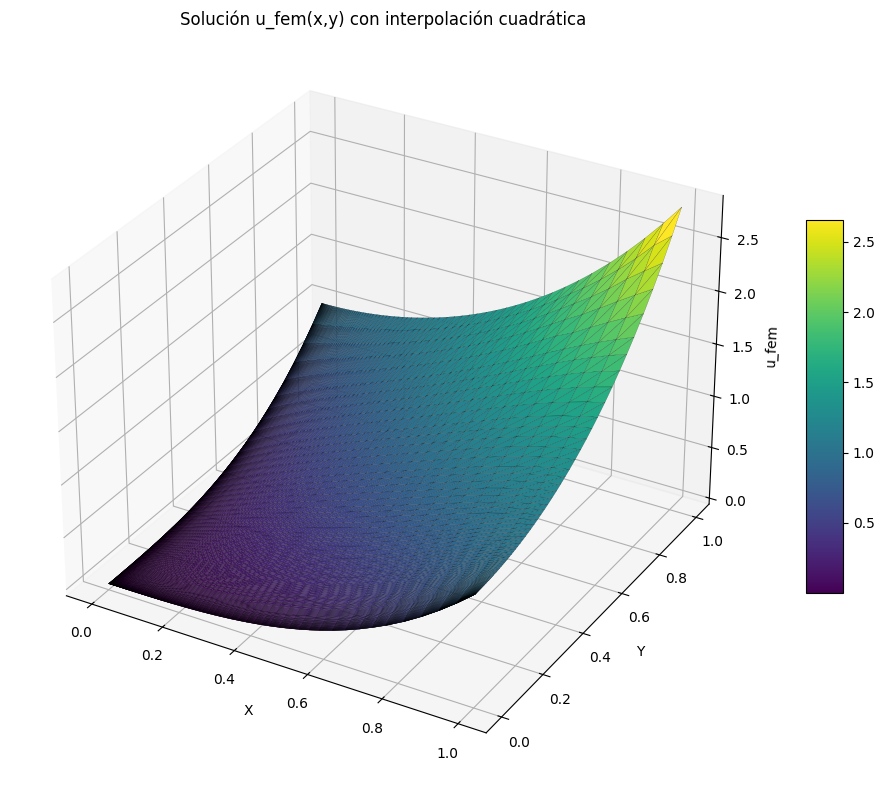

In [8]:
#Bien, ahora es nesesario calcular la solucion,
#Conozco todos lo que esta en la frontera diritchlet
Estructure.solve_matrix()
plot_u_surface_quadratic_elements(nodes, elements, use_attr="u_fem")  # solución FEM



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_relative_error_surface_3d(nodes, elements):
    """
    Grafica una superficie 3D del error relativo nodal entre u FEM y u exacto,
    usando solo los vértices de los elementos LST (primeros 3 nodos de cada uno).
    """
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])

    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) / (np.abs(u_ref) + eps)

    # Usar solo los 3 primeros nodos (vértices) para visualización
    triangles = []
    for elem in elements:
        if len(elem.node_ids) >= 3:
            tri = [elem.node_ids[0] - 1, elem.node_ids[1] - 1, elem.node_ids[2] - 1]
            triangles.append(tri)

    triangles = np.array(triangles)
    triang = Triangulation(x, y, triangles)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(triang, error_rel, cmap='plasma', edgecolor='k', linewidth=0.2)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Error relativo')
    ax.set_title('Error relativo nodal entre u FEM y u exacto')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

    # Resumen de errores
    print(f"Máximo error relativo: {np.max(error_rel):.2e}")
    print(f"Promedio error relativo: {np.mean(error_rel):.2e}")
    print(f"Mínimo error relativo: {np.min(error_rel):.2e}")


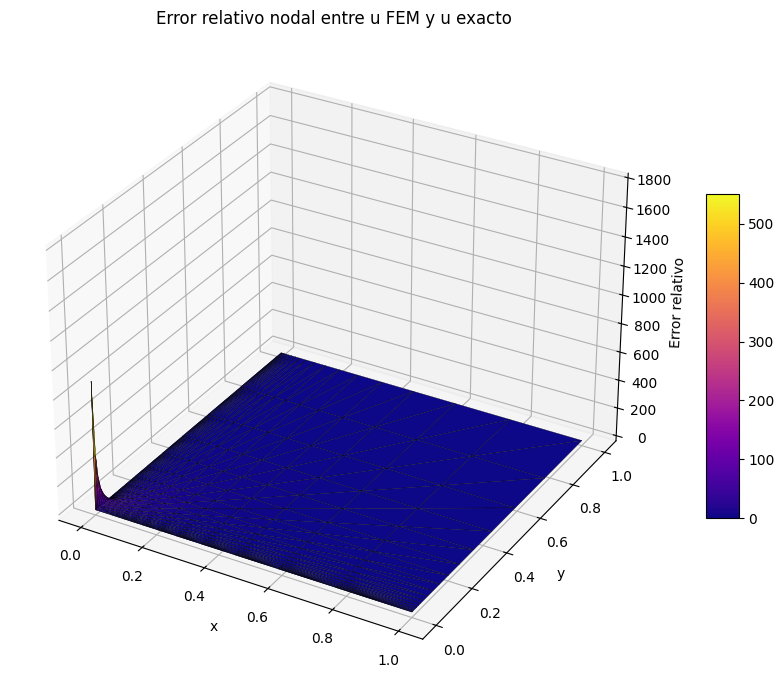

Máximo error relativo: 1.79e+03
Promedio error relativo: 2.01e+01
Mínimo error relativo: 0.00e+00


In [10]:
plot_relative_error_surface_3d(nodes, elements)


In [11]:
import numpy as np

def semi_norm_H1_0(alpha, orden=5):
    """
    Calcula |u|^2_{H^1_0(Ω)} = ∫_Ω |∇u(x,y)|² dxdy, donde u = (x² + y²)^{α/2},
    y Ω = [0,1] × [0,1] usando cuadratura de Gauss-Legendre.
    """
    puntos, pesos = np.polynomial.legendre.leggauss(orden)
    puntos = 0.5 * (puntos + 1)
    pesos = 0.5 * pesos

    total = 0.0

    for i in range(orden):
        for j in range(orden):
            x = puntos[i]
            y = puntos[j]
            w = pesos[i] * pesos[j]

            r2 = x**2 + y**2
            if r2 == 0 and alpha < 1:
                grad2 = 0.0  # evitar singularidad
            else:
                grad2 = alpha**2 * r2**(alpha - 1)

            total += grad2 * w

    return total  # ya es la semi-norma al cuadrado


result = semi_norm_H1_0(alpha, orden=5)
print(f"Resultado de |u|^2_{{H^1_0(Ω)}}: {result:.4f}")


Resultado de |u|^2_{H^1_0(Ω)}: 5.6000


In [12]:
from scipy.sparse import csr_matrix

fem_solution = Estructure.femm_solution()
print(f"Solución FEM (xᵀ K x): {fem_solution:.4f}")

Solución FEM (xᵀ K x): 3.9528
